In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

from tqdm.notebook import tqdm

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

In [3]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

In [4]:
import youtokentome as yttm

In [5]:
data_1 = pd.read_csv('data/SPAM text message 20170820 - Data.csv', index_col='Category').rename(columns={'Message':'text'},)
data_2 = pd.read_csv('data/spam.csv', index_col='v1')[['v2']].rename(columns={'v2':'text'})
data_3 = pd.read_csv('data/spam_ham_dataset.csv', index_col='label')[['text']]

In [20]:
data_3.text = data_3.text.apply(lambda x: x.lower().replace('subject: ', '').replace('\n', ' ').replace('\r', ''))

In [21]:
data = pd.concat([data_1, data_2, data_3]).drop_duplicates()
data.index = pd.Index(map(lambda x: int(x == 'spam'), data.index))
data

,text
0,"Go until jurong point, crazy.. Available only ..."
0,Ok lar... Joking wif u oni...
1,Free entry in 2 a wkly comp to win FA Cup fina...
0,U dun say so early hor... U c already then say...
0,"Nah I don't think he goes to usf, he lives aro..."
...,...
1,slutty milf wants to meet you take that ! ' il...
0,put the 10 on the ft the transport volumes dec...
0,3 / 4 / 2000 and following noms hpl can ' t ta...
0,industrial worksheets for august 2000 activity...


In [22]:
def oversample(X, y):
#     oversize = len(X[y==0])
    oversize = len(X[y==1])
    oversamples = np.random.choice(X[y==1], size=oversize)
    return np.hstack([X, oversamples]), np.hstack([y, np.ones(oversize)]),

In [23]:
def bpe_trasform(X_train, X_test):
    with open('X_train', 'w') as f:
        for el in X_train:
            f.write(el+'\n')  
            
    model_path='tmp'
    yttm.BPE.train(data='X_train', vocab_size=5000, model=model_path)

    bpe = yttm.BPE(model=model_path)
    
    X_train_enc = bpe.encode(X_train.tolist())
    X_test_enc = bpe.encode(X_test.tolist())
    
    X_train_tokened = []
    for text in X_train_enc:
        X_train_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    X_test_tokened = []
    for text in X_test_enc:
        X_test_tokened.append(' '.join(bpe.id_to_subword(el) for el in text))
        
    return np.array(X_train_tokened), np.array(X_test_tokened)

In [24]:
def train_val(clf, X_train, X_test, y_train, y_test, vectorizer, full=False):

    train_vec = vectorizer.fit_transform(X_train) 
    test_vec  = vectorizer.transform(X_test)
    
    clf.fit(train_vec, y_train)
    pred = clf.predict(test_vec)

    if full:
        plot_confusion_matrix(clf, test_vec, y_test)

        print(classification_report(y_test, pred))
    
    return matthews_corrcoef(y_test, pred)

In [25]:
def process_split(texts, train_indxs, test_indxs, clf, vectorizer, full=False):
        train_data, test_data = texts.iloc[train_indxs], texts.iloc[test_indxs]
        
        X_train, y_train = train_data.values, train_data.index
        X_test, y_test = test_data.values, test_data.index
        
        X_train_tokened, X_test_tokened = bpe_trasform(X_train, X_test)
        X_train_tokened, y_train = oversample(X_train_tokened, y_train)
        
        return train_val(clf, X_train_tokened, X_test_tokened, y_train, y_test, vectorizer, full)

In [26]:
def cross_val(clf, data, vectorizer, full=False):
    res = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train_indxs, test_indxs in tqdm(kf.split(data.text, data.index), total=5):
        res.append(process_split(data.text, train_indxs, test_indxs, clf, vectorizer, full))
    return res

In [27]:
nltk.download('wordnet')
stop_words = stopwords.words("english")

[nltk_data] Downloading package wordnet to /home/stas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
texts = data.text.apply(lambda x:' '.join([word.lower() for word in x.split(' ') if word.lower not in stop_words]))


In [29]:
test_num = len(texts)//5
test_indxs = np.random.choice(len(texts), size=test_num, replace=False)
test_indxs_set = set(test_indxs)
train_indxs = [i for i in range(len(texts)) if i not in test_indxs_set]

In [30]:
vectorizer = TfidfVectorizer(  
    lowercase=True,      
    stop_words='english' 
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1687
           1       0.96      0.90      0.93       467

    accuracy                           0.97      2154
   macro avg       0.97      0.94      0.95      2154
weighted avg       0.97      0.97      0.97      2154



0.9083969101912985

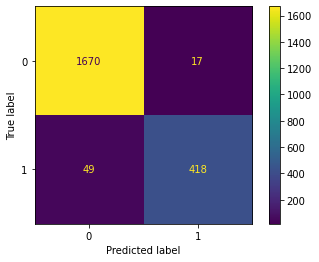

In [31]:
classifier = RandomForestClassifier()
process_split(texts, train_indxs, test_indxs, classifier, vectorizer, True)

In [32]:
indx_to_terms = {val: key for key, val in vectorizer.vocabulary_.items()}

In [33]:
# посмотрим на наиболее важные для случайного леса признаки
fi = classifier.feature_importances_

# узнав индексы самых важных признаков можно восстановить, каким токенам они соостветуют.
indx_sort = np.argsort(fi)[::-1]
tmp = indx_sort[fi[indx_sort]>1e-3]

# Дополнительно отфильтровав список от мусора, токены, важные для принятия решения о классификации спам/неспам.
[indx_to_terms[indx] for indx in tmp if len(indx_to_terms[indx])>3]

['http',
 'mobile',
 'free',
 'click',
 '0871',
 'claim',
 'prize',
 'enron',
 'stop',
 '2000',
 'reply',
 'offer',
 'best',
 'text',
 'daren',
 'online',
 'removed',
 'service',
 'tone',
 'urgent',
 'cash',
 'remove',
 'order',
 'info',
 'forwarded',
 'subject',
 'prescription',
 'software',
 '1000',
 'attached',
 'guaranteed',
 'email',
 'viagra',
 'visit',
 '2004',
 'thanks',
 'cheap',
 'prices',
 'ment',
 '2001',
 'meter',
 'money',
 'private',
 'message',
 'landline',
 'deal',
 '0870',
 'save',
 'contact',
 'awarded',
 'selected',
 'draw',
 'dating',
 'holiday',
 'questions',
 'know',
 'receive',
 '2003',
 'customer',
 'pobox',
 'quality',
 'camera',
 'latest',
 'paliourg',
 'women',
 'meds',
 'rolex',
 'cost',
 'code',
 'real',
 'video',
 'special',
 'land',
 'pres',
 'world',
 'note',
 'rate',
 '150p',
 'regards',
 'doctor',
 'farmer',
 'huge',
 'agra',
 '150ppm',
 'just',
 'need',
 'ation']

In [59]:
word = 'http'
s = data[data.index == 0].text
ham_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

s = data[data.index == 1].text
spam_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

print(f'"{word}"\n \
  in ham appears in {ham_ratio}% of texts; \n \
  in spam appears in {spam_ratio}% of texts')

"http"
   in ham appear in 1.6% of texts; 
   in spam appear in 21.23% of texts


In [60]:
word = 'mobile'
s = data[data.index == 0].text
ham_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

s = data[data.index == 1].text
spam_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

print(f'"{word}"\n \
  in ham appears in {ham_ratio}% of texts; \n \
  in spam appears in {spam_ratio}% of texts')

"mobile"
   in ham appear in 0.33% of texts; 
   in spam appear in 8.63% of texts


In [61]:
word = 'free'
s = data[data.index == 0].text
ham_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

s = data[data.index == 1].text
spam_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

print(f'"{word}"\n \
  in ham appears in {ham_ratio}% of texts; \n \
  in spam appears in {spam_ratio}% of texts')

"free"
   in ham appear in 3.28% of texts; 
   in spam appear in 13.36% of texts


In [63]:
word = 'ation'
s = data[data.index == 0].text
ham_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

s = data[data.index == 1].text
spam_ratio = np.round(s.str.contains(word).sum()/len(s)*100, 2)

print(f'"{word}"\n \
  in ham appears in {ham_ratio}% of texts; \n \
  in spam appears in {spam_ratio}% of texts')

"ation"
   in ham appear in 16.64% of texts; 
   in spam appear in 29.09% of texts


Как видно, полученные в целом соотвествуют нашему восприятию что содержиться в спаме -- сайты, слова, побуждающие к действию и прочее.

Также видно, что лесу важна не столько значительность различия популярностей токена в каждом из классов, сколько уникальность токена в целом. 